In [3]:
import pandas as pd
from numba import prange, jit
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
from CODE.AttentionDCA_python.src.plot_functions import attention_heads, attention_heads_interaction
cwd = os.getcwd()

from matplotlib.colors import LinearSegmentedColormap

import seaborn as sns

colors_cmap = ["#A21622","#FE5D21","#F9DB6D","#E4F7DE","#81C8D9","#4D5AFF","#13152D"]
colors_palette = ["#4D5AFF","#FE5D21","#F6C928","#02B64D","#EFABFF","#E072A4","#337064","#A21622"]
cmap = LinearSegmentedColormap.from_list("mycmap", colors_cmap)
cmap_palette=sns.color_palette(colors_cmap)

mypalette=sns.color_palette(colors_palette)

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
#mpl.rc("text", usetex=True)
plt.rc('font', size=12)  
#mpl.rc("text.latex", preamble=r"\usepackage{amsmath}")

#mpl.rcParams['xtick.major.pad'] = -3    # if you want to specify the pixels between the ticks and the labels
#mpl.rcParams['ytick.major.pad'] = -4    # if you want to specify the pixels between the ticks and the labels

fig_size_half = (3.1, 2.4)                   # (width, height in inches) -> check that it fits perfectly on the page the way you want it to
figsize_full = (6,5)
fig_margins = {
    "top": 0.9,                         # percentage from figure to top
    "bottom": 0.1,                      # percentage from figure to bottom
    "left": 0.1,                        # percentage from figure to left
    "right": 0.95,                      # percentage from figure to right
    "wspace": 0.4,                      # weird thing to control width distribution of spacing when using multiple axes
    "hspace": 0.4,                      # weird thing to control height distribution of spacing when using multiple axes
}

fig_margins_half ={
    "left": 0.18,
    "bottom": 0.2, 
    "right": 0.94, 
    "top": 0.88, 
    "wspace": 0.8, 
    "hspace": 0.3
}
#import os
#os.environ["PATH"] += os.pathsep + "/Library/TeX/texbin" # jupyter notebook doesn't know where to find latex (at least for me), so you need to tell it where to look
#print(os.getenv("PATH"))

# plt.rcParams['mathtext.fontset'] = 'stix'
# plt.rcParams['font.family'] = 'STIXGeneral'
# plt.rcParams.update({'font.size': 12})
# plt.rcParams['text.usetex'] = True
# plt.rcParams['text.latex.preamble'] = r'\usepackage{bm}'

In [4]:
# Fasta functions
from matching import paired_fasta_to_labeled_array, load_seqs, tokenize_seqs
from matching import standard_amino_acids, write_fasta
tokens_protein = "ACDEFGHIKLMNPQRSTVWY-"

In [5]:
def_val=10000
@jit(nopython=True) #parallelise using numba
def interaction_energy_pair_species_label(
    seqA, seqB, A, V, default_value=def_val
):
    """
    Takes labeled TOKENIZED sequences from interacting families A and B and calculates interaction energy between them.
    Input sequences should have one label for interaction pair and one label for species.
    If they're not from the same species, the interaction energy is set to default_value
    """
    #print("interaction_energy")

    labelsA=seqA[:2]
    labelsB=seqB[:2]
    seqA=seqA[2:]
    seqB=seqB[2:]

    seqtot=np.concatenate((seqA,seqB))
    L = len(seqtot)

    L_A = len(seqA)
    
    if labelsA[0] != labelsB[0]:
        return default_value

    else:
        E_int = 0
        for i in range(L_A):
            ind_a = seqtot[i]
            for j in range(L_A,L):
                ind_b = seqtot[j]

                E_int += np.sum(A[:, i, j] * V[:, ind_a, ind_b]) # J(i,j+L_A,ind_a,ind_b,A,V)

    return E_int


def read_tensor_from_txt(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    
    # Read the dimensions from the first line
    dims = list(map(int, lines[0].strip().split()))
    
    # Initialize a list to hold the tensor data
    tensor_data = []
    
    current_slice = []
    for line in lines[1:]:
        line = line.strip()
        if line.startswith("Slice"):
            if current_slice:  # If there is an existing slice, save it
                tensor_data.append(current_slice)
                current_slice = []
        elif line:  # Process non-empty lines
            current_slice.append(list(map(float, line.split(','))))
    
    if current_slice:  # Append the last slice
        tensor_data.append(current_slice)
    
    # Convert the list back into a tensor with the original dimensions
    tensor = torch.tensor(tensor_data).view(*dims)
    return tensor

In [6]:
from numba import prange, jit

def_val=10000

@jit(nopython=True) #parallelise using numba
def interaction_energy_pair_species_label(
    seqA, seqB, A, V, default_value=def_val
):
    """
    Takes LABELED TOKENIZED sequences from interacting families A and B and calculates interaction energy between them.
    Input sequences should have one label for interaction pair and one label for species.
    If they're not from the same species, the interaction energy is set to default_value
    """
    #print("interaction_energy")

    labelsA=seqA[:2]
    labelsB=seqB[:2]
    seqA=seqA[2:]
    seqB=seqB[2:]

    seqtot=np.concatenate((seqA,seqB))
    L = len(seqtot)

    L_A = len(seqA)
    
    if labelsA[0] != labelsB[0]:
        return default_value


    else:
        E_int = 0
        for i in range(L_A):
            ind_a = seqtot[i]
            for j in range(L_A,L):
                ind_b = seqtot[j]

                E_int += np.sum(A[:, i, j] * V[:, ind_a, ind_b]) # J(i,j+L_A,ind_a,ind_b,A,V)

    return E_int

@jit(nopython=True) #parallelise using numba
def full_energy_pair_species_label(
    seqA, seqB, A, V, default_value=def_val
):
    """
    Takes labeled TOKENIZED sequences from interacting families A and B and calculates interaction energy between them.
    Input sequences should have one label for interaction pair and one label for species.
    If they're not from the same species, the interaction energy is set to default_value
    """
    #print("full_energy")
    labelsA=seqA[:2]
    labelsB=seqB[:2]
    seqA=seqA[2:]
    seqB=seqB[2:]

    seqtot=np.concatenate((seqA,seqB))
    L = len(seqtot)

    if labelsA[0] != labelsB[0]:
        E_int = default_value

    else:
        E_int = 0
        for i in range(L):
            ind_a = seqtot[i]
            for j in range(i):
                #print(i,j)
                ind_b = seqtot[j]

                # if ind_a == len(symbols) - 1 or ind_b == len(symbols) - 1:
                #     continue
                
                E_int += np.sum(A[:, i, j] * V[:, ind_a, ind_b]) # J(i,j,ind_a,ind_b,A,V)
    
    return E_int


@jit(nopython=True) #parallelise using numba
def energy_no_int_pair_species_label(
    seqA, seqB, A, V, default_value=def_val
):
    """
    Takes labeled TOKENIZED sequences from interacting families A and B and calculates sum of the energies without interaction part.
    Input sequences should have one label for interaction pair and one label for species.
    If they're not from the same species, the interaction energy is set to default_value
    """
    #print("energy_no_int")
    labelsA=seqA[:2]
    labelsB=seqB[:2]
    seqA=seqA[2:]
    seqB=seqB[2:]

    seqtot=np.concatenate((seqA,seqB))
    L = len(seqtot)

    L_A = len(seqA)

    if labelsA[0] != labelsB[0]:
        return default_value

    else:
        E = 0
        for i in range(L_A):
            ind_a = seqtot[i]
            for j in range(i):
                #print(i,j)
                ind_b = seqtot[j]
                E += np.sum(A[:, i, j] * V[:, ind_a, ind_b]) # J(i,j+L_A,ind_a,ind_b,A,V)

        for i in range(L_A,L):
            ind_a = seqtot[i]
            for j in range(L_A,i):
                #print(i,j)
                ind_b = seqtot[j]
                E += np.sum(A[:, i, j] * V[:, ind_a, ind_b])

    return E

@jit(nopython=True, parallel=True) #parallelise using numba
def energy_calculation_tks_species_label(seqsA, seqsB, A, V):
    """
    seqsA and seqsB must be in tokens, not amino acid symbols!! (and labeled)
    """
    N_A=len(seqsA)
    N_B=len(seqsB)
    scores = np.zeros((N_A, N_B), dtype=np.float32)
    for i in prange(N_A):
        seqA=seqsA[i]
        for j in range(N_B):
            seqB=seqsB[j]
            scores[i,j] = interaction_energy_pair_species_label(seqA, seqB, A, V)
    return scores

@jit(nopython=True, parallel=True) #parallelise using numba
def energy_calculation_tks_species_label_full(seqsA, seqsB, A, V):
    """
    seqsA and seqsB must be in tokens, not amino acid symbols!! (and unlabeled)
    """
    N_A=len(seqsA)
    N_B=len(seqsB)
    scores = np.zeros((N_A, N_B), dtype=np.float32)
    for i in prange(N_A):
        seqA=seqsA[i]
        for j in range(N_B):
            seqB=seqsB[j]
            scores[i,j] = full_energy_pair_species_label(seqA, seqB, A, V)
    return scores


@jit(nopython=True, parallel=True) #parallelise using numba
def energy_calculation_tks_species_label_noint(seqsA, seqsB, A, V):
    """
    seqsA and seqsB must be in tokens, not amino acid symbols!! (and unlabeled)
    """
    N_A=len(seqsA)
    N_B=len(seqsB)
    scores = np.zeros((N_A, N_B), dtype=np.float32)
    for i in prange(N_A):
        seqA=seqsA[i]
        for j in range(N_B):
            seqB=seqsB[j]
            E=energy_no_int_pair_species_label(seqA, seqB, A, V)
            scores[i,j] = E
    return scores



def prep_spectrum_plots_energy_species(seqsA,seqsB,A, V):
    
    seqsA_tks=tokenize_seqs(seqsA[:,2:], tokens=tokens_protein)
    seqsB_tks=tokenize_seqs(seqsB[:,2:], tokens=tokens_protein)

    seqsA_all=np.concatenate((seqsA[:,:2], seqsA_tks), axis=1)
    seqsA_all = seqsA_all.astype(np.uint16)
    seqsB_all=np.concatenate((seqsB[:,:2], seqsB_tks), axis=1)
    seqsB_all = seqsB_all.astype(np.uint16)

    print("tokenized seqs")
    
    score=energy_calculation_tks_species_label(seqsA_all,seqsB_all, A, V)
    score_save = score.copy()
    print("energy calculated")

    nbseqsA, nbseqsB = np.shape(score)
    label_B=np.zeros(np.shape(score), dtype=np.uint16)
    correct_energies=np.zeros(np.shape(score), dtype=np.float64)

    for i in prange(nbseqsA):
        for j in range(nbseqsB):
            label_B[i,j]=j
            correct_energies[i,j]=1 if seqsA_all[i,0]==seqsB_all[j,0] and seqsA_all[i,1]==seqsB_all[j,1] else 0

    label_B=label_B.flatten()
    correct_energies=correct_energies.flatten()
    score=score.flatten()  

    return label_B, score, correct_energies, score_save

def prep_spectrum_plots_energy_species_full(seqsA,seqsB,A, V):
    
    seqsA_tks=tokenize_seqs(seqsA[:,2:], tokens=tokens_protein)
    seqsB_tks=tokenize_seqs(seqsB[:,2:], tokens=tokens_protein)

    seqsA_all=np.concatenate((seqsA[:,:2], seqsA_tks), axis=1)
    seqsA_all = seqsA_all.astype(np.uint16)
    seqsB_all=np.concatenate((seqsB[:,:2], seqsB_tks), axis=1)
    seqsB_all = seqsB_all.astype(np.uint16)

    print("tokenized seqs")
    
    score=energy_calculation_tks_species_label_full(seqsA_all,seqsB_all, A, V)
    score_save=score.copy()
    print("energy calculated")

    nbseqsA, nbseqsB = np.shape(score)
    label_B=np.zeros(np.shape(score), dtype=np.uint16)
    correct_energies=np.zeros(np.shape(score), dtype=np.float64)

    for i in prange(nbseqsA):
        for j in range(nbseqsB):
            label_B[i,j]=j
            correct_energies[i,j]=1 if seqsA_all[i,0]==seqsB_all[j,0] and seqsA_all[i,1]==seqsB_all[j,1] else 0

    label_B=label_B.flatten()
    correct_energies=correct_energies.flatten()
    score=score.flatten()  

    return label_B, score, correct_energies, score_save

def prep_spectrum_plots_energy_species_noint(seqsA,seqsB,A, V):
    
    seqsA_tks=tokenize_seqs(seqsA[:,2:], tokens=tokens_protein)
    seqsB_tks=tokenize_seqs(seqsB[:,2:], tokens=tokens_protein)

    seqsA_all=np.concatenate((seqsA[:,:2], seqsA_tks), axis=1)
    seqsA_all = seqsA_all.astype(np.uint16)
    seqsB_all=np.concatenate((seqsB[:,:2], seqsB_tks), axis=1)
    seqsB_all = seqsB_all.astype(np.uint16)

    print("tokenized seqs")
    
    score=energy_calculation_tks_species_label_noint(seqsA_all,seqsB_all, A, V)
    
    print("energy calculated")

    nbseqsA, nbseqsB = np.shape(score)
    label_B=np.zeros(np.shape(score), dtype=np.uint16)
    correct_energies=np.zeros(np.shape(score), dtype=np.float64)

    for i in prange(nbseqsA):
        for j in range(nbseqsB):
            label_B[i,j]=j
            correct_energies[i,j]=1 if seqsA_all[i,0]==seqsB_all[j,0] and seqsA_all[i,1]==seqsB_all[j,1] else 0

    label_B=label_B.flatten()
    correct_energies=correct_energies.flatten()
    score=score.flatten()  

    return label_B, score, correct_energies

### Load couplings

In [7]:
H = 150
d = 23
loss_type = "without_J"
family = "HK-RR" # CHANGE
family="hsp70"

#dist_map_file = cwd + "/CODE/DataAttentionDCA/{family}/HK-RR_old_preprocessed.map".format(family=family) # CHANGE
dist_map_file=cwd + "/CODE/DataAttentionDCA/{family}/hsp70.map".format(family=family)

epochs = 300

#folder = "HK-RR_174_train" # CHANGE
folder = "{H}_{d}_{family}_{losstype}_{epochs}".format(H=H, d=d, family=family, losstype=loss_type, epochs=epochs)
K = read_tensor_from_txt(cwd + "/results/" + folder + "/K_tensor.txt")
Q = read_tensor_from_txt(cwd + "/results/" + folder + "/Q_tensor.txt")
V = read_tensor_from_txt(cwd + "/results/" + folder + "/V_tensor.txt")

if V.shape[-1]!=21:
    print("!!!!! V.shape=",V.shape)
    V=V[:,1:,1:]


A = attention_heads(Q, K, V, sym=True)


!!!!! V.shape= torch.Size([150, 22, 22])


Check couplings:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


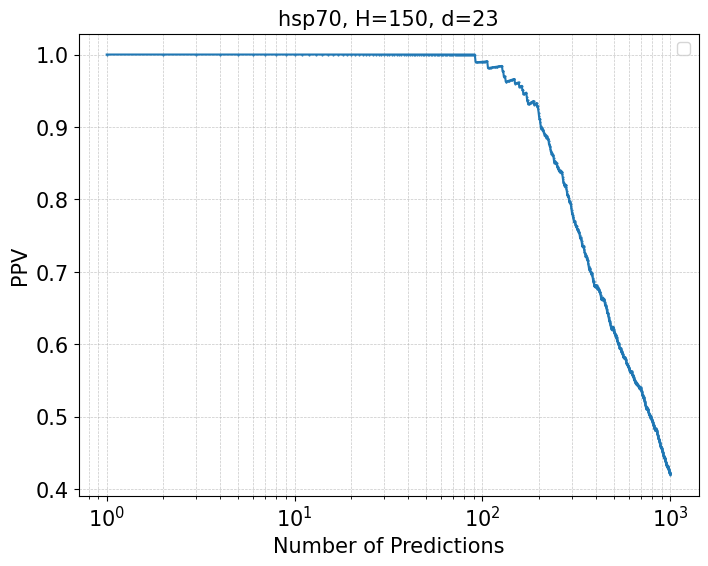

In [8]:
from CODE.AttentionDCA_python.src.dcascore import score, compute_PPV_from_map
from CODE.AttentionDCA_python.src.plot_functions import graphPPV

ranking, _ = score(Q, K, V)
PPVs = [compute_PPV_from_map(ranking, dist_map_file, cutoff=8,nb_pred=1000)]  

labels = ["AttentionDCA"]
figtitle = "{family}, H={H}, d={d}".format(family=family, H=H, d=d)
graphPPV(PPVs, labels, figtitle, fig_size=(8, 6), colors=["b"], fs=15)

V = np.array(V)
A = np.array(A)

In [10]:
L_A=377 # CHANGE
MSA_A_label, MSA_B_label=paired_fasta_to_labeled_array("./CODE/DataAttentionDCA/hsp70/hsp70_test_new_filtered.fasta",L_A=L_A) # CHANGE
#MSA_A_label, MSA_B_label=paired_fasta_to_labeled_array("./CODE/DataAttentionDCA/HK-RR/HK-RR_174_test.fasta",L_A=64) # CHANGE
_, ids= load_seqs("./CODE/DataAttentionDCA/hsp70/hsp70_test_new_filtered.fasta",return_ID=True)
MSA_A_label[:,1]=MSA_A_label[:,1].astype(np.uint16) # Needed for numba
MSA_B_label[:,1]=MSA_B_label[:,1].astype(np.uint16)

In [15]:
seqsA_tks=tokenize_seqs(MSA_A_label[:,2:],tokens_protein)
seqsB_tks=tokenize_seqs(MSA_B_label[:,2:],tokens_protein)

seqsA_all=np.concatenate((MSA_A_label[:,:2], seqsA_tks), axis=1)
seqsA_all = seqsA_all.astype(np.uint16)
seqsB_all=np.concatenate((MSA_B_label[:,:2], seqsB_tks), axis=1)
seqsB_all = seqsB_all.astype(np.uint16)

N_A=np.shape(seqsA_tks)[0]
N_B, L_B=np.shape(seqsB_tks)

all_pairs=np.zeros((N_A*N_B,L_A+L_B),dtype=np.uint8)
all_correct_pairs=np.zeros((N_A, L_A + L_B), dtype=np.uint8)
#energies=np.zeros(N_A*N_B,dtype=np.float32)
for i in prange(N_A):
    if i%100==0:
        print(round(i*100/N_A,3))
    seqA=seqsA_tks[i]
    for j in range(N_B):
        seqB=seqsB_tks[j]

        all_pairs[i*N_B+j]=np.concatenate((seqA,seqB))
        if seqsA_all[i,1]==seqsB_all[j,1]: 
            all_correct_pairs[i] = np.concatenate((seqA, seqB))
        #energies[i*N_B+j]=interaction_energy_pair_species_label(seqsA_all[i], seqsB_all[j], A, V)


# # Reshape energies to a 2D array
# energies_2d = energies.reshape(N_A, N_B)

# # Extract diagonal and non-diagonal elements
# correct_scores = np.diag(energies_2d)
# incorrect_scores = energies_2d[~np.eye(N_A, N_B, dtype=bool)]
# incorrect_scores = incorrect_scores[incorrect_scores != def_val]

0.0
2.917
5.834
8.751
11.669
14.586
17.503
20.42
23.337
26.254
29.172
32.089
35.006
37.923
40.84
43.757
46.674
49.592
52.509
55.426
58.343
61.26
64.177
67.095
70.012
72.929
75.846
78.763
81.68
84.597
87.515
90.432
93.349
96.266
99.183


In [16]:
label_B, score, correct_energies, score_save = prep_spectrum_plots_energy_species(MSA_A_label,MSA_B_label,A, V)
df_energy=pd.DataFrame({'label B':label_B, 'score':score, 'correct':correct_energies})

correct_scores = df_energy[df_energy['correct'] == True]['score'].values
incorrect_scores = df_energy[df_energy['correct'] == False]['score'].values
incorrect_scores = incorrect_scores[incorrect_scores < def_val]

tokenized seqs
energy calculated


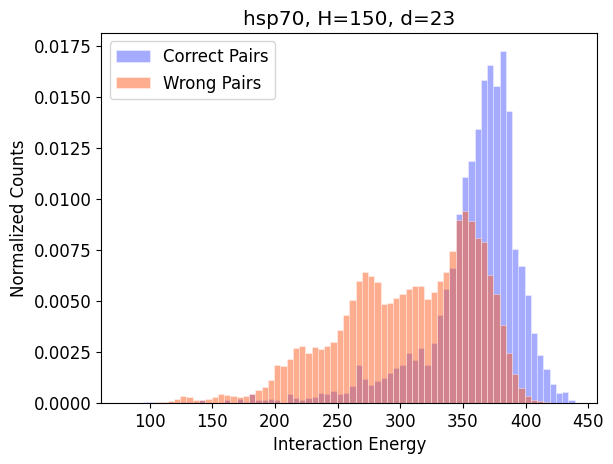

In [17]:
bin_width = 5

min_bins=min(min(correct_scores), min(incorrect_scores))
max_bins=max(max(correct_scores), max(incorrect_scores))
bins=np.arange(min_bins,max_bins+bin_width,bin_width)

plt.figure()
plt.hist(correct_scores, bins=bins, alpha=0.5, label='Correct Pairs', color=mypalette[0], density=True, edgecolor='white', linewidth=0.5)
plt.hist(incorrect_scores, bins=bins, alpha=0.5, label='Wrong Pairs', color=mypalette[1], density=True, edgecolor='white', linewidth=0.5)
plt.xlabel("Interaction Energy")
plt.ylabel("Normalized Counts")
plt.legend()#bbox_to_anchor=(0.5, 0.7))
plt.title("{family}, H={H}, d={d}".format(family=family, H=H, d=d))
#plt.xlim(328,420)
#plt.savefig('interaction_energy_scores_species_{family}_{H}_{d}_L_A={L_A}.pdf'.format(family=family, H=H, d=d, L_A=L_A))
plt.show()

We want to focus on the wrong pairs whose energies overlap with the correct ones. We choose to focus on pairs with an interaction energy value between 328 and 420.

In [18]:
indices_to_consider=np.where((score_save < 420) & (score_save > 328))
energies_selected=score_save[indices_to_consider]

In [ ]:
energies_selected_correct=[]
energies_selected_incorrect=[]
A_selected_correct=[]
B_selected_correct=[]
A_selected_incorrect=[]
B_selected_incorrect=[]
indices_selected_correct=[]
indices_selected_incorrect=[]
pairs_correct=[]
pairs_incorrect=[]
for i in range(np.shape(indices_to_consider)[1]):
    index_A=indices_to_consider[0][i]
    index_B=indices_to_consider[1][i]
    print(energies_selected[i],index_A, index_B)
    if index_A==index_B:
        energies_selected_correct.append(energies_selected[i])
        A_selected_correct.append(seqsA_tks[index_A])
        B_selected_correct.append(seqsB_tks[index_B])
        indices_selected_correct.append([index_A, index_B])
        pairs_correct.append(all_pairs[index_A*N_B+index_B])
    else:
        energies_selected_incorrect.append(energies_selected[i])
        A_selected_incorrect.append(seqsA_tks[index_A])
        B_selected_incorrect.append(seqsB_tks[index_B])
        indices_selected_incorrect.append([index_A, index_B])
        pairs_incorrect.append(all_pairs[index_A*N_B+index_B])
A_selected_correct=np.array(A_selected_correct, dtype=np.uint8)
B_selected_correct=np.array(B_selected_correct, dtype=np.uint8)
A_selected_incorrect=np.array(A_selected_incorrect, dtype=np.uint8)
B_selected_incorrect=np.array(B_selected_incorrect, dtype=np.uint8)
pairs_correct=np.array(pairs_correct, dtype=np.uint8)
pairs_incorrect=np.array(pairs_incorrect, dtype=np.uint8)

371.34723 0 0
381.05417 1 1
384.2096 1 2
387.34412 1 3
374.876 1 4
373.39136 2 1
383.9466 2 2
386.356 2 3
373.3468 2 4
375.62195 3 1
383.49704 3 2
387.11438 3 3
380.92557 3 4
368.71967 4 1
372.64117 4 2
379.8652 4 3
376.82996 4 4
397.22287 5 5
389.34555 6 6
350.02075 6 7
376.84323 6 10
355.50256 7 6
362.27258 7 7
344.95978 7 10
398.45584 8 8
399.80045 8 9
360.94577 8 11
391.7714 9 8
360.298 9 11
383.6992 10 6
354.41687 10 7
381.81107 10 10
369.48026 11 8
384.93884 11 9
364.58557 11 11
373.167 12 12
406.31833 13 13
378.50455 13 14
385.96848 14 13
374.93964 14 14
397.311 15 15
361.12958 15 16
396.31094 15 17
385.69873 16 15
378.05444 16 16
400.23242 16 17
392.52673 17 15
363.62183 17 16
404.3173 17 17
365.7705 18 18
382.54593 18 19
342.0108 19 18
388.11896 19 19
364.35138 20 20
365.0509 23 23
331.27655 24 23
401.04736 25 25
360.40228 26 26
363.35367 27 27
345.05878 28 28
332.39536 28 29
344.14774 28 32
365.16785 28 33
346.22937 28 34
334.0413 28 36
349.43393 29 29
336.96872 29 32
370.274

In [232]:
hdists_pairs_correct_incorrect = []
for i,correct_pair in enumerate(pairs_correct):
	print(i*100/len(pairs_correct))
	hamming_distances = np.sum(pairs_incorrect != correct_pair, axis=1)
	hdists_pairs_correct_incorrect.append(hamming_distances)
hdists_pairs_correct_incorrect = np.array(hdists_pairs_correct_incorrect)

0.0
0.03431708991077557
0.06863417982155114
0.1029512697323267
0.13726835964310227
0.17158544955387783
0.2059025394646534
0.24021962937542896
0.27453671928620454
0.3088538091969801
0.34317089910775567
0.37748798901853126
0.4118050789293068
0.4461221688400824
0.4804392587508579
0.5147563486616334
0.5490734385724091
0.5833905284831846
0.6177076183939602
0.6520247083047358
0.6863417982155113
0.7206588881262869
0.7549759780370625
0.789293067947838
0.8236101578586136
0.8579272477693891
0.8922443376801648
0.9265614275909403
0.9608785175017158
0.9951956074124915
1.029512697323267
1.0638297872340425
1.0981468771448182
1.1324639670555936
1.1667810569663692
1.201098146877145
1.2354152367879203
1.269732326698696
1.3040494166094716
1.338366506520247
1.3726835964310227
1.4070006863417983
1.4413177762525737
1.4756348661633494
1.509951956074125
1.5442690459849004
1.578586135895676
1.6129032258064515
1.6472203157172272
1.6815374056280028
1.7158544955387782
1.7501715854495539
1.7844886753603295
1.81880

In [ ]:
hdists_pairs_correct_incorrect_fullrange = []
for i,correct_pair in enumerate(all_correct_pairs):
	print(i*100/len(pairs_correct))
	hamming_distances = np.sum(pairs_incorrect != correct_pair, axis=1)
	hdists_pairs_correct_incorrect_fullrange.append(hamming_distances)
hdists_pairs_correct_incorrect_fullrange = np.array(hdists_pairs_correct_incorrect_fullrange)

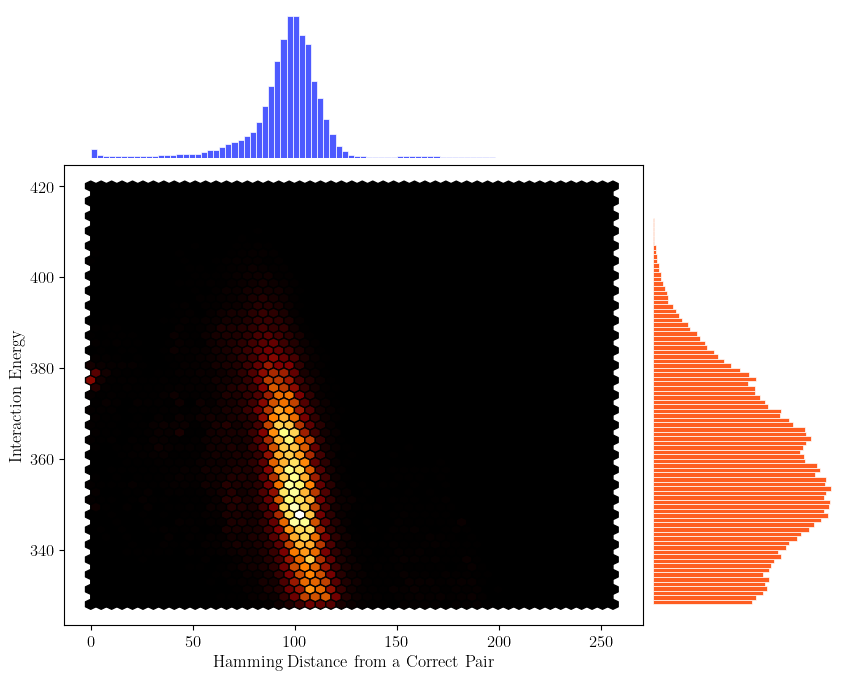

In [ ]:
distances_incorrect = np.min(hdists_pairs_correct_incorrect_fullrange, axis=0)
energies_incorrect = energies_selected_incorrect

x = distances_incorrect
y = energies_incorrect

# Set up the figure with GridSpec
fig = plt.figure(figsize=(10, 8))
# Define a grid with 4 rows and 4 columns
gs = fig.add_gridspec(4, 4, wspace=0.05, hspace=0.05)

# Main scatter plot: occupies rows 1:4 and columns 0:3
ax_scatter = fig.add_subplot(gs[1:4, 0:3])
# Histogram for x (top): occupies row 0 and columns 0:3
ax_histx = fig.add_subplot(gs[0, 0:3], sharex=ax_scatter)
# Histogram for y (right): occupies rows 1:4 and column 3
ax_histy = fig.add_subplot(gs[1:4, 3], sharey=ax_scatter)

# Scatter plot
ax_scatter.hexbin(distances_incorrect, energies_incorrect, gridsize=50, cmap='afmhot', 
                 alpha=1, edgecolors='black')

bin_width = 3
bins_dist=np.arange(min(x),max(x)+bin_width,bin_width)
# Histogram for x (on top)
ax_histx.hist(x, bins=bins_dist, color=mypalette[0], edgecolor='white', linewidth=0.5)
ax_histx.axis('off')  # Optionally hide axis ticks
ax_scatter.set_xlabel("Hamming Distance from a Correct Pair")
ax_scatter.set_ylabel("Interaction Energy")

bin_width = 1
bins_energy=np.arange(min(y),max(y)+bin_width,bin_width)
# Histogram for y (on right)
ax_histy.hist(y, bins=bins_energy, orientation='horizontal', color=mypalette[1], edgecolor='white', linewidth=0.5)
ax_histy.axis('off')  # Optionally hide axis ticks

plt.show()


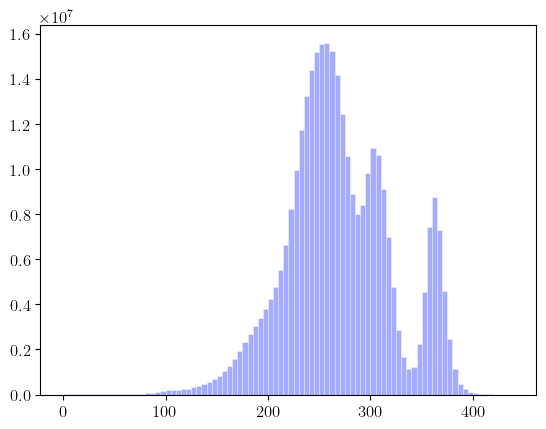

In [ ]:
data=hdists_pairs_correct_incorrect.flatten()
bin_width = 5
bins=np.arange(min(data),max(data)+bin_width,bin_width)
plt.figure()
plt.hist(data, bins=bins, alpha=0.5, label='Correct vs Incorrect Pairs', color=mypalette[0], edgecolor='white', linewidth=0.5)
plt.show()

In [144]:
hdists_pairs_correct_correct=np.sum(pairs_correct[:, None, :] != pairs_correct[None, :, :], axis=2)

In [145]:
np.fill_diagonal(hdists_pairs_correct_correct, 1000)
np.where(hdists_pairs_correct_correct==0)

(array([], dtype=int64), array([], dtype=int64))

# Check how different partners of identical domains are

In [146]:
# Load test sequences (dataset without duplicates)

L_A=377 # CHANGE
MSA_A_label, MSA_B_label=paired_fasta_to_labeled_array("./CODE/DataAttentionDCA/hsp70/hsp70_test_new_filtered.fasta",L_A=L_A) # CHANGE

MSA_A_label[:,1]=MSA_A_label[:,1].astype(np.uint16) # Needed for numba
MSA_B_label[:,1]=MSA_B_label[:,1].astype(np.uint16)

_, ids = load_seqs("./CODE/DataAttentionDCA/hsp70/hsp70_test_new_filtered.fasta", return_ID=True)
family="hsp70_filtered"

In [147]:
seqs_A=np.array(MSA_A_label[:,2:], dtype=str)
seqs_B=np.array(MSA_B_label[:,2:], dtype=str)

seqsA_unique, _ = np.unique(seqs_A, axis=0, return_index=True)
seqsB_unique, _ = np.unique(seqs_B, axis=0, return_index=True)

print("We have {n} unique sequences of the NBD and {m} unique sequences of the SBD".format(n=seqsA_unique.shape[0], m=seqsB_unique.shape[0]))

We have 3335 unique sequences of the NBD and 3280 unique sequences of the SBD


In [148]:
from collections import defaultdict
from itertools import combinations
# Create a dictionary to group row indices by their unique tuple representation
row_groups = defaultdict(list)

# Group rows by their tuple representation (hashable format for dictionary keys)
for idx, row in enumerate(seqs_A):
    row_groups[tuple(row)].append(idx)

# Convert to a list of lists containing grouped indices
grouped_indices_A = [indices for indices in row_groups.values() if len(indices) > 1]

distances_B=[]
for group in grouped_indices_A:
    for combo in combinations(group, 2):
        distances_B.append(np.sum(seqs_B[combo[0]]!=seqs_B[combo[1]]))

row_groups = defaultdict(list)

# Group rows by their tuple representation (hashable format for dictionary keys)
for idx, row in enumerate(seqs_B):
    row_groups[tuple(row)].append(idx)

# Convert to a list of lists containing grouped indices
grouped_indices_B = [indices for indices in row_groups.values() if len(indices) > 1]


distances_A=[]
ids_big_difference=[]
for group in grouped_indices_B:
    for combo in combinations(group, 2):
        dist_A=np.sum(seqs_A[combo[0]]!=seqs_A[combo[1]])
        distances_A.append(dist_A)
        if dist_A>40:
            ind1=combo[0]
            ind2=combo[1]
            if ids[ind1] not in ids_big_difference:
                ids_big_difference.append(ids[ind1])
            if ids[ind2] not in ids_big_difference:
                ids_big_difference.append(ids[ind2])
            print(combo)
            print(dist_A)

(699, 1709)
122
(853, 1709)
151
(1001, 1709)
122
(1302, 1709)
123
(1706, 1709)
124
(1709, 3237)
123
(772, 3247)
61
(826, 1998)
91
(880, 1998)
106
(1998, 3110)
107
(1616, 3399)
63


In [149]:
ids_big_difference

['A0A0L0HBP2|Spizellomyces punctatus (strain DAOM BR117)',
 'A0A3N5Y2B9|Alteromonas sediminis',
 'A0A2E3BGI0|Pelagibacterales bacterium',
 'A0A933Y0Z4|Planctomycetota bacterium',
 'A0A3S2E3X7|Mesorhizobium sp. M7A.F.Ca.US.001.01.1.1',
 'A0A4P8EHV1|Pseudorhodobacter turbinis',
 'A0A0Q0I1I5|Pseudomonas syringae pv. theae',
 'A0A3N4EDY2|Shewanella psychromarinicola',
 'A0A3N4GAT2|Gordonia oryzae',
 'A0A930MV77|Selenomonas sp',
 'A0A2S7VVJ9|Photobacterium angustum',
 'A0A158P1Z1|Atta cephalotes (Leafcutter ant)',
 'A0A0M8X8N2|Streptomyces sp. NRRL B-1140',
 'A0A0J1LNK0|Citrobacter sp. MGH106',
 'A0A0C4EK03|Puccinia triticina (isolate 1-1 / race 1 (BBBD)) (Brown leaf rust fungus)']

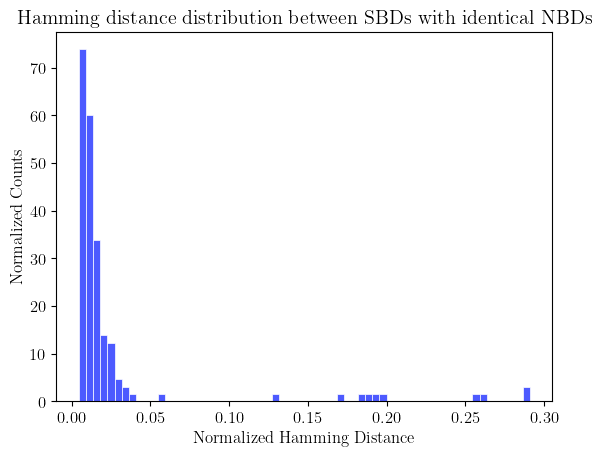

In [150]:
bin_width = 1

bins=np.arange(min(distances_B),max(distances_B)+bin_width,bin_width)

normalized_distances_B=np.array(distances_B)/seqs_B.shape[1]
plt.figure()
plt.hist(normalized_distances_B, bins=bins/seqs_B.shape[1], color=mypalette[0], density=True, edgecolor='white', linewidth=0.5)
plt.xlabel("Normalized Hamming Distance")
plt.ylabel("Normalized Counts")
plt.title("Hamming distance distribution between SBDs with identical NBDs")
plt.savefig('./figs/hdist_SBDs_identical_NBDs.pdf')
plt.show()

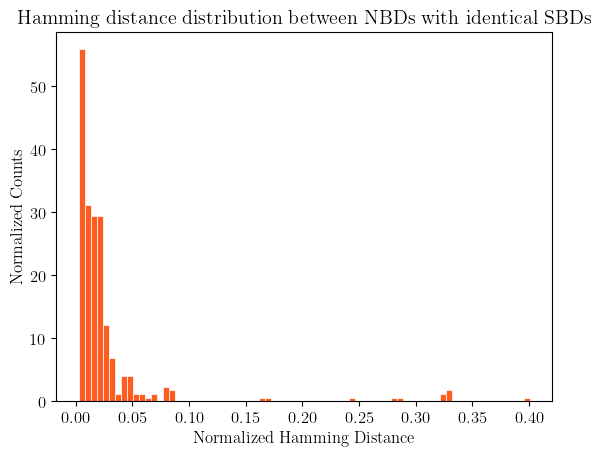

In [151]:
bin_width = 2

bins=np.arange(min(distances_A),max(distances_A)+bin_width,bin_width)

plt.figure()
plt.hist(np.array(distances_A)/seqs_A.shape[1], bins=bins/seqs_A.shape[1], color=mypalette[1], density=True, edgecolor='white', linewidth=0.5)
plt.xlabel("Normalized Hamming Distance")
plt.ylabel("Normalized Counts")
plt.title("Hamming distance distribution between NBDs with identical SBDs")
plt.savefig('./figs/hdist_NBDs_identical_SBDs.pdf')
plt.show()